In [1]:
pip install qiskit

   ━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━ 4.3/4.3 MB 46.8 MB/s eta 0:00:00
   ━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━ 2.1/2.1 MB 52.5 MB/s eta 0:00:00
   ━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━ 49.7/49.7 kB 2.0 MB/s eta 0:00:00
   ━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━ 39.4/39.4 MB 35.0 MB/s eta 0:00:00
   ━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━ 107.5/107.5 kB 5.0 MB/s eta 0:00:00
Note: you may need to restart the kernel to use updated packages.


In [2]:
pip install qiskit_algorithms

   ━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━ 308.6/308.6 kB 5.7 MB/s eta 0:00:00
Note: you may need to restart the kernel to use updated packages.


## _*Quantum SVM*_

### Introduction

Please refer to [this file](https://github.com/Qiskit/qiskit-tutorials/blob/master/legacy_tutorials/aqua/machine_learning/qsvm_classification.ipynb) for introduction.

In [3]:
pip install qiskit-machine-learning

     ━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━ 133.4/133.4 kB 3.2 MB/s eta 0:00:00
  Preparing metadata (setup.py) ... - \ | done
   ━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━ 97.8/97.8 kB 216.0 kB/s eta 0:00:00
  Created wheel for fastdtw: filename=fastdtw-0.3.4-cp310-cp310-linux_x86_64.whl size=118275 sha256=ee66daa687f9efa828e09b3fd5b5adfae5aff0da3b5cd3942b7e089ae9e8a4ad
  Stored in directory: /root/.cache/pip/wheels/73/c8/f7/c25448dab74c3acf4848bc25d513c736bb93910277e1528ef4
Successfully built fastdtw
Note: you may need to restart the kernel to use updated packages.


     ┌──────────┐┌────────────────────────────────────────────────────────┐
q_0: ┤ Ry(θ[0]) ├┤0                                                       ├
     ├──────────┤│                                                        │
q_1: ┤ Ry(θ[0]) ├┤1                                                       ├
     ├──────────┤│                                                        │
q_2: ┤ Ry(θ[0]) ├┤2                                                       ├
     ├──────────┤│                                                        │
q_3: ┤ Ry(θ[0]) ├┤3                                                       ├
     ├──────────┤│  ZZFeatureMap(x[0],x[1],x[2],x[3],x[4],x[5],x[6],x[7]) │
q_4: ┤ Ry(θ[0]) ├┤4                                                       ├
     ├──────────┤│                                                        │
q_5: ┤ Ry(θ[0]) ├┤5                                                       ├
     ├──────────┤│                                                        │
q_6: ┤ Ry(θ[

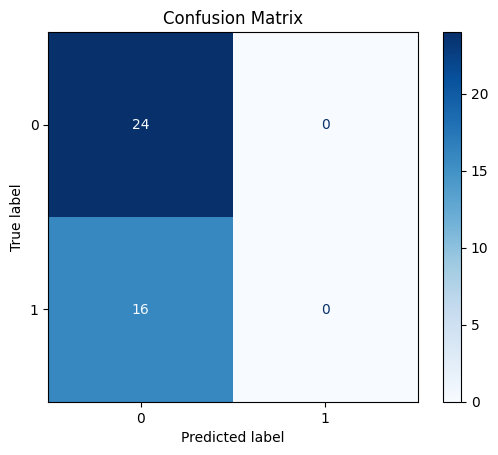

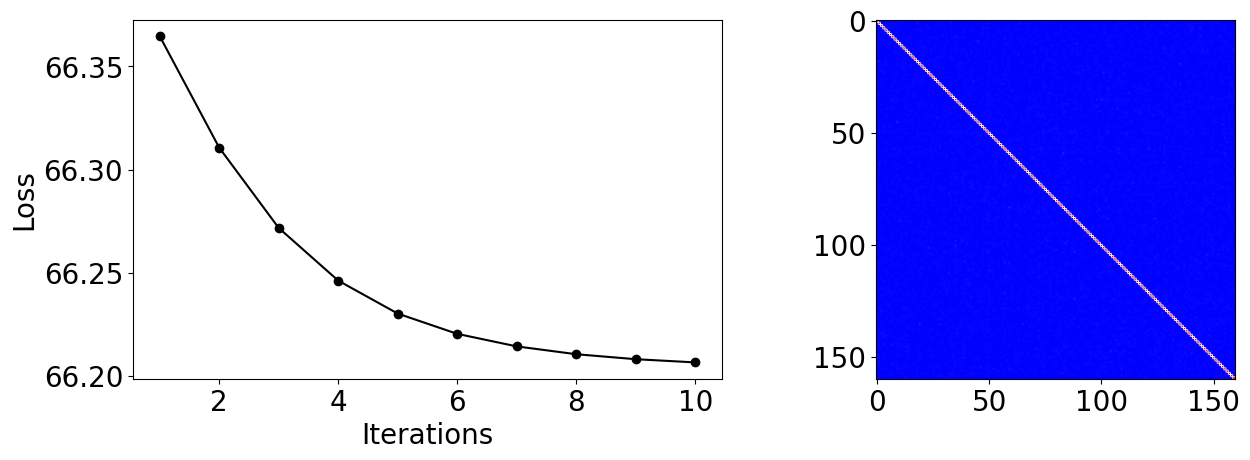

In [4]:
# Import necessary libraries
import pandas as pd
import numpy as np
from sklearn.model_selection import train_test_split
from sklearn.preprocessing import StandardScaler
from sklearn import metrics
import matplotlib.pyplot as plt
from sklearn.metrics import confusion_matrix, ConfusionMatrixDisplay, accuracy_score, precision_score, recall_score, f1_score

# Qiskit imports
from qiskit import QuantumCircuit
from qiskit.circuit import ParameterVector
from qiskit.visualization import circuit_drawer
from qiskit.circuit.library import ZZFeatureMap
from qiskit_algorithms.optimizers import SPSA
from qiskit_machine_learning.kernels import TrainableFidelityQuantumKernel
from qiskit_machine_learning.kernels.algorithms import QuantumKernelTrainer
from qiskit_machine_learning.algorithms import QSVC

# Load and preprocess the dataset
data = pd.read_csv('/kaggle/input/diabitic/diabetes2.csv')

# Drop unnecessary columns (PatientID)
data = data.drop(columns=['PatientID'])

# Handle missing values if any
data = data.dropna()
data = data.iloc[:200]
# Normalize the features
features = data.drop(columns=['Diabetic'])
target = data['Diabetic']
scaler = StandardScaler()
features_scaled = scaler.fit_transform(features)

# Split the dataset
X_train, X_test, y_train, y_test = train_test_split(features_scaled, target, test_size=0.2, random_state=42)

# Quantum feature map
training_params = ParameterVector("θ", 1)
fm0 = QuantumCircuit(features.shape[1])
for i in range(features.shape[1]):
    fm0.ry(training_params[0], i)

# Use ZZFeatureMap to represent input data
fm1 = ZZFeatureMap(features.shape[1])

# Create the feature map, composed of our two circuits
fm = fm0.compose(fm1)

print(circuit_drawer(fm))
print(f"Trainable parameters: {training_params}")

# Quantum kernel
quant_kernel = TrainableFidelityQuantumKernel(feature_map=fm, training_parameters=training_params)

# Optimizer and Quantum Kernel Trainer
class QKTCallback:
    """Callback wrapper class."""
    def __init__(self) -> None:
        self._data = [[] for i in range(5)]

    def callback(self, x0, x1=None, x2=None, x3=None, x4=None):
        self._data[0].append(x0)
        self._data[1].append(x1)
        self._data[2].append(x2)
        self._data[3].append(x3)
        self._data[4].append(x4)

    def get_callback_data(self):
        return self._data

    def clear_callback_data(self):
        self._data = [[] for i in range(5)]

cb_qkt = QKTCallback()
spsa_opt = SPSA(maxiter=10, callback=cb_qkt.callback, learning_rate=0.05, perturbation=0.05)

qkt = QuantumKernelTrainer(
    quantum_kernel=quant_kernel, loss="svc_loss", optimizer=spsa_opt, initial_point=[np.pi / 2]
)

# Train the quantum kernel
qka_results = qkt.fit(X_train, y_train)
optimized_kernel = qka_results.quantum_kernel
print(qka_results)

# Quantum SVM (QSVC)
qsvc = QSVC(quantum_kernel=optimized_kernel)

# Fit the QSVC
qsvc.fit(X_train, y_train)

# Predict the labels for the test set
labels_test = qsvc.predict(X_test)

# Check predictions
print("Predictions: ", labels_test)
print("True Labels: ", y_test.values)

# Evaluate the test accuracy, precision, recall, and F1 score
accuracy_test = accuracy_score(y_true=y_test, y_pred=labels_test)
precision_test = precision_score(y_true=y_test, y_pred=labels_test, zero_division=1)
recall_test = recall_score(y_true=y_test, y_pred=labels_test)
f1_test = f1_score(y_true=y_test, y_pred=labels_test)

print(f"Accuracy: {accuracy_test}")
print(f"Precision: {precision_test}")
print(f"Recall: {recall_test}")
print(f"F1 Score: {f1_test}")

# Compute the confusion matrix
cm = confusion_matrix(y_test, labels_test)

# Plot the confusion matrix
disp = ConfusionMatrixDisplay(confusion_matrix=cm, display_labels=[0, 1])
disp.plot(cmap=plt.cm.Blues)
plt.title("Confusion Matrix")
plt.show()

# Plot the loss and kernel matrix
plot_data = cb_qkt.get_callback_data()  # callback data
K = optimized_kernel.evaluate(X_train)  # kernel matrix evaluated on the training samples

plt.rcParams["font.size"] = 20
fig, ax = plt.subplots(1, 2, figsize=(14, 5))
ax[0].plot([i + 1 for i in range(len(plot_data[0]))], np.array(plot_data[2]), c="k", marker="o")
ax[0].set_xlabel("Iterations")
ax[0].set_ylabel("Loss")
ax[1].imshow(K, cmap='bwr')
fig.tight_layout()
plt.show()
